# Transfer learning image classifier

In this notebook i will explore application of activation maps in CNN trained on classification task nor the object detection.

In [1]:
import keras
import tensorflow as tf
import vis # keras-vis
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras import Model

Using TensorFlow backend.


In [2]:
# Load pretrained model
from keras.applications.vgg16 import VGG16, preprocess_input

model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [30]:
# froze the pretrained layers
for layer in model.layers:
  layer.trainable = False

# Choose last layer you want from pretrained model
last_layer = model.get_layer('fc1')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4096)


Decision about how many layers and which we want to train is considered hyperparameter but for sake of this notebook I took first Dense layer. Then I add one my Dense layer and output Dense layer with softmax, both are trainable.

In [31]:
x = layers.Dense(4096, activation='relu')(last_output)
x = layers.Dense(6, activation='softmax')(x)

MODEL = Model( model.input, x)
MODEL.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(r'E:\data',
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    target_size = (224, 224))

Found 14293 images belonging to 6 classes.


Its good idea to use generators almost with every image classification problem

In [33]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

with tf.device('/device:GPU:0'):
    history = MODEL.fit_generator(
                train_generator,
                steps_per_epoch = 50,
                epochs = 10,
                verbose = 1)

Epoch 1/10
50/50 [==============================] - 61s 1s/step - loss: 11.3950 - acc: 0.6288
Epoch 2/10
50/50 [==============================] - 85s 2s/step - loss: 1.1893 - acc: 0.7625
Epoch 3/10
50/50 [==============================] - 36s 716ms/step - loss: 0.6880 - acc: 0.8175
Epoch 4/10
50/50 [==============================] - 36s 716ms/step - loss: 0.5840 - acc: 0.8313
Epoch 5/10
50/50 [==============================] - 34s 683ms/step - loss: 1.0101 - acc: 0.7962
Epoch 6/10
50/50 [==============================] - 38s 768ms/step - loss: 0.4084 - acc: 0.8441
Epoch 7/10
50/50 [==============================] - 34s 676ms/step - loss: 0.4083 - acc: 0.8425
Epoch 8/10
50/50 [==============================] - 32s 636ms/step - loss: 0.4119 - acc: 0.8438
Epoch 9/10
50/50 [==============================] - 30s 610ms/step - loss: 0.5205 - acc: 0.8163
Epoch 10/10
50/50 [==============================] - 32s 641ms/step - loss: 0.3616 - acc: 0.8587


I train only for 10 epochs, 50 steps per each. It should be enough for demonstration purposes.

### Testing on new images
Following images are new for model since they are not contained in dataset and also I have downloaded first thing so it may be completly different from training dataset

In [34]:
MODEL.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

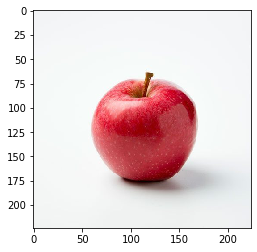

In [35]:
from keras.preprocessing.image import load_img, img_to_array

_img = load_img(r"E:\Dokumenty\apple2.jpg",target_size=(224,224))
plt.imshow(_img)
plt.show()

In [36]:
classlabel = {0: 'apple', 1: 'cat', 2:'dog', 3:'face', 4:'horses', 5:'humans'}
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))

In [41]:
from vis.visualization import visualize_cam
from vis.utils import utils

layer_idx = utils.find_layer_idx(MODEL, 'dense_6')
penultimate_layer_idx = utils.find_layer_idx(MODEL, "block2_conv2") 

img = img_to_array(_img)
seed_input = img
y_pred = MODEL.predict(np.expand_dims(img/255, axis=0))
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

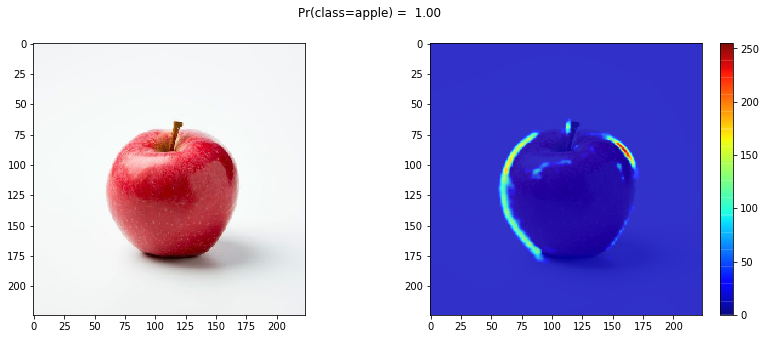

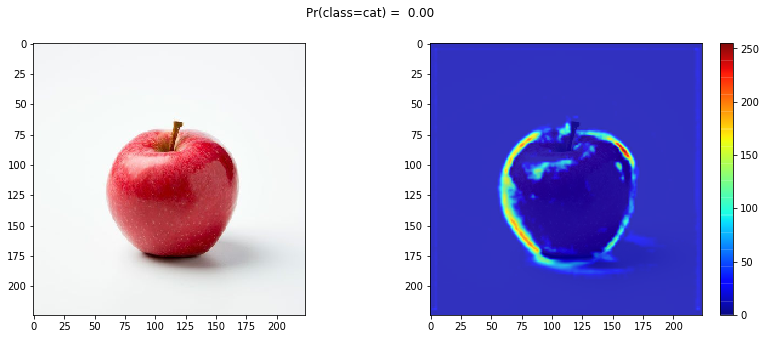

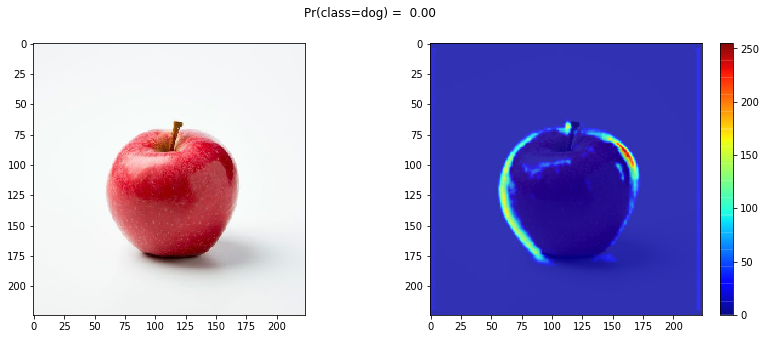

In [42]:
topNclass = 3
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

From apple class plot we see that very important feature are shape and stem. Also these also are features that distinguish apple from other classes. 

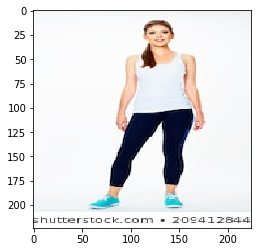

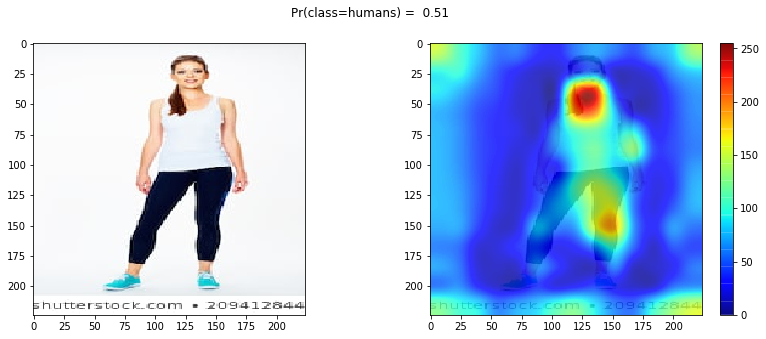

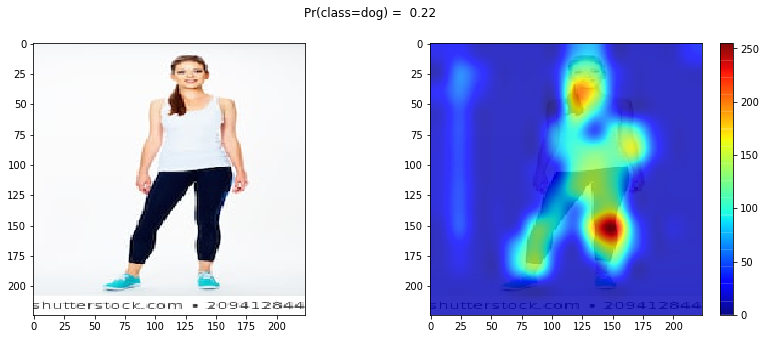

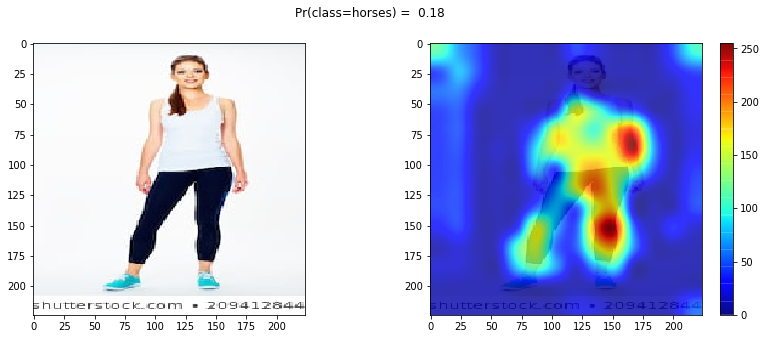

In [47]:
# lets take a look at some human picture

_img = load_img(r"E:\Dokumenty\woman.jpg",target_size=(224,224))
plt.imshow(_img)

img = img_to_array(_img)
y_pred = MODEL.predict(np.expand_dims(img/255, axis=0))
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

layer_idx = utils.find_layer_idx(MODEL, 'dense_6')
penultimate_layer_idx = utils.find_layer_idx(MODEL, "block5_conv2") 
seed_input = img

for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

Its interesting that model estimates this is human with probability only 51%. But we can see that neck is really important feature.

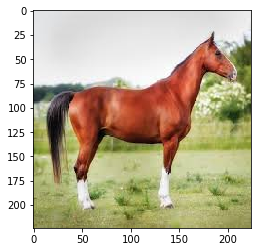

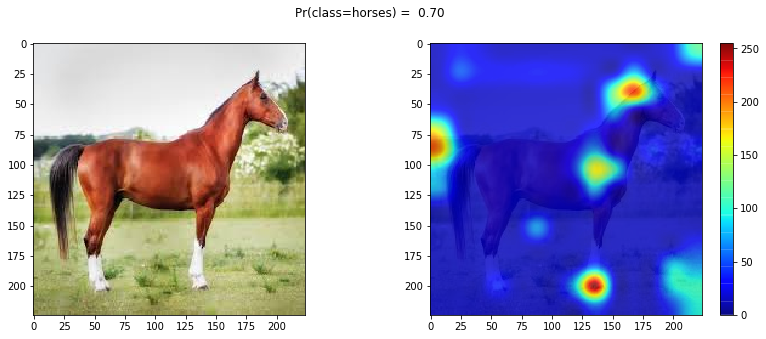

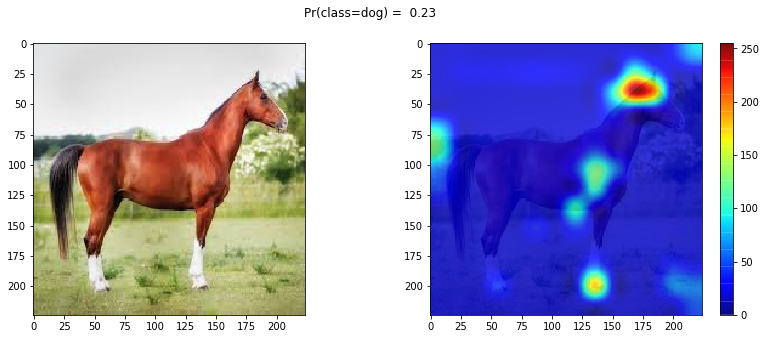

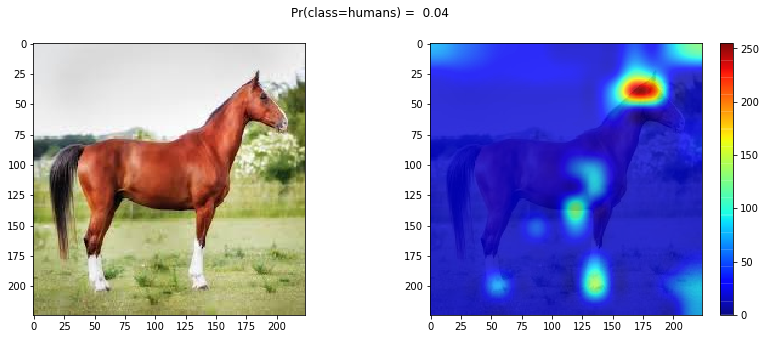

In [48]:
# OK, what about horse with visible only two legs?

_img = load_img(r"E:\Dokumenty\horse.jpg",target_size=(224,224))
plt.imshow(_img)

img = img_to_array(_img)
y_pred = MODEL.predict(np.expand_dims(img/255, axis=0))
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

layer_idx = utils.find_layer_idx(MODEL, 'dense_6')
penultimate_layer_idx = utils.find_layer_idx(MODEL, "block5_conv2") 
seed_input = img

for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)


All these have very similar feature map. It seems that for this type of horse is important mane and hoofs

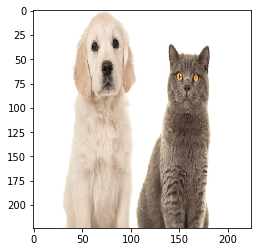

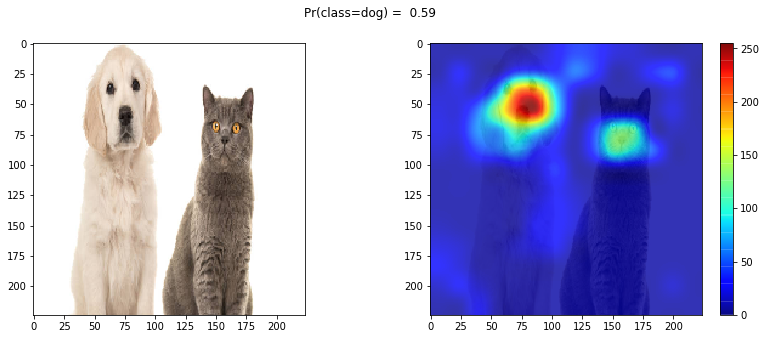

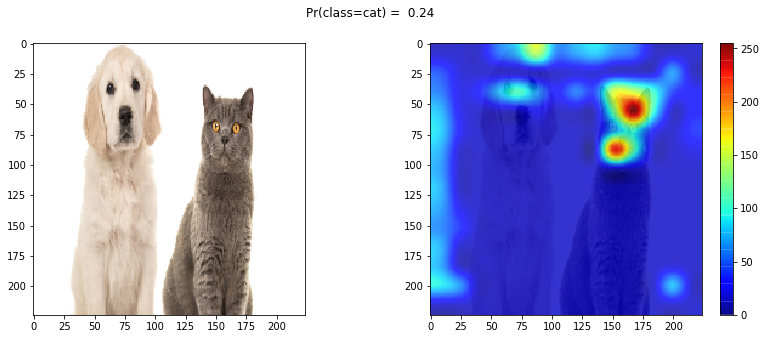

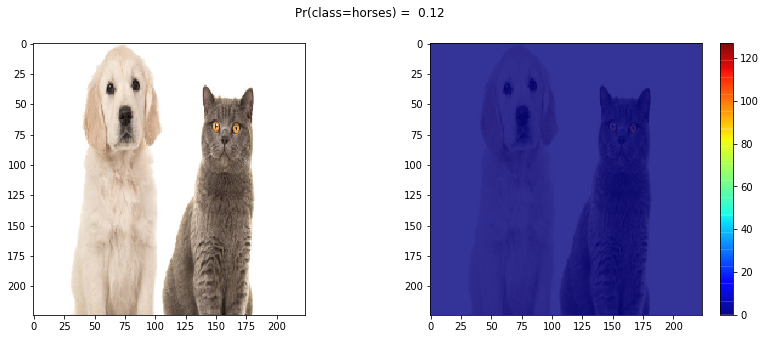

In [50]:
_img = load_img(r"E:\Dokumenty\dog_cat.jpg",target_size=(224,224))
plt.imshow(_img)

img = img_to_array(_img)
y_pred = MODEL.predict(np.expand_dims(img/255, axis=0))
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

layer_idx = utils.find_layer_idx(MODEL, 'dense_5')
penultimate_layer_idx = utils.find_layer_idx(MODEL, "block5_conv2") 
seed_input = img

for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

Wow Im quite suprised that even without labeling it recognizes that on the picture is dog and cat (and it looks on them). 

Yumi recommends that we should swap softmax with linear activation function, lets see the impact

In [58]:
from vis.utils import utils
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(MODEL, 'dense_6')
# Swap softmax with linear
MODEL.layers[layer_idx].activation = keras.activations.linear
MODEL.layers[-1].activation

<function keras.activations.linear(x)>

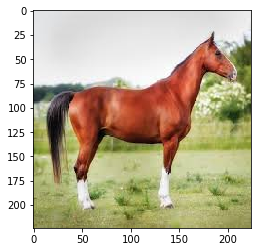

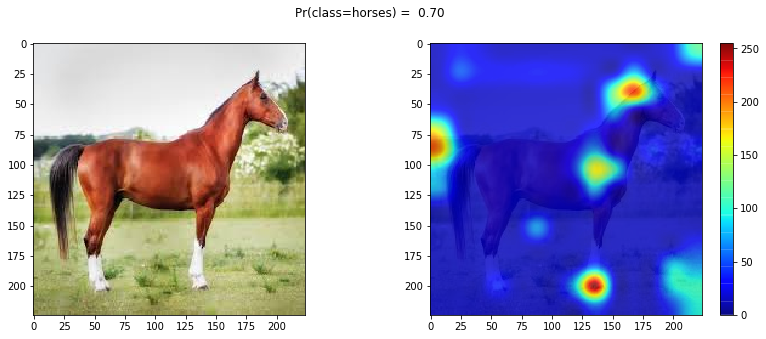

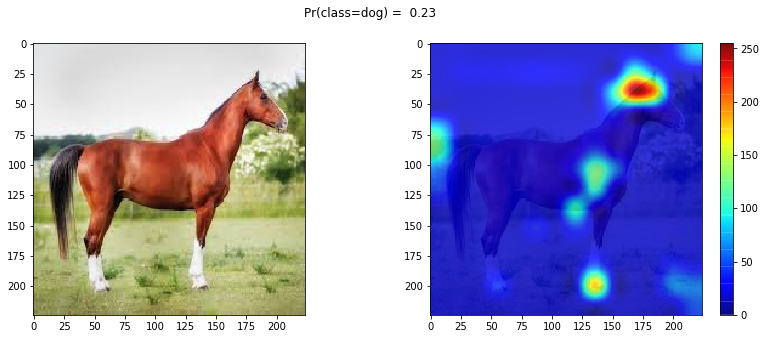

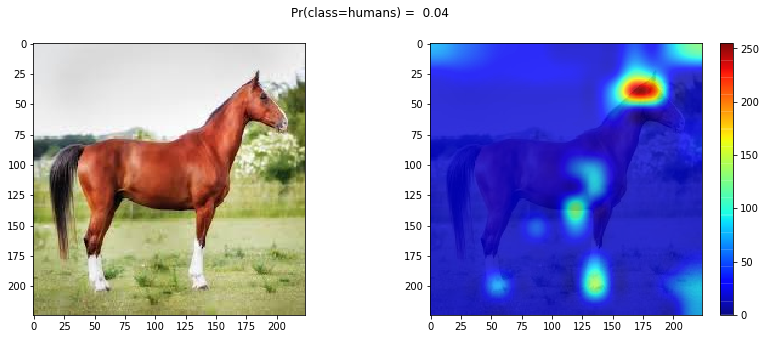

In [59]:
_img = load_img(r"E:\Dokumenty\horse.jpg",target_size=(224,224))
plt.imshow(_img)

img = img_to_array(_img)
y_pred = MODEL.predict(np.expand_dims(img/255, axis=0))
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

layer_idx = utils.find_layer_idx(MODEL, 'dense_6')
penultimate_layer_idx = utils.find_layer_idx(MODEL, "block5_conv2") 
seed_input = img

for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

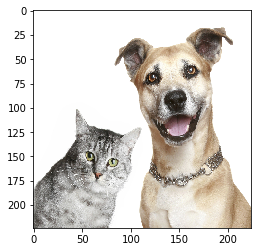

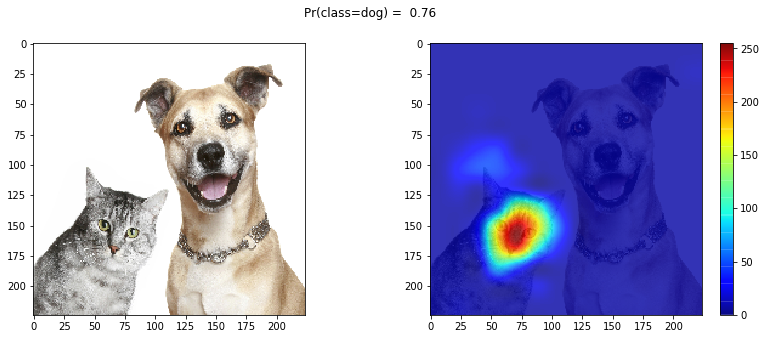

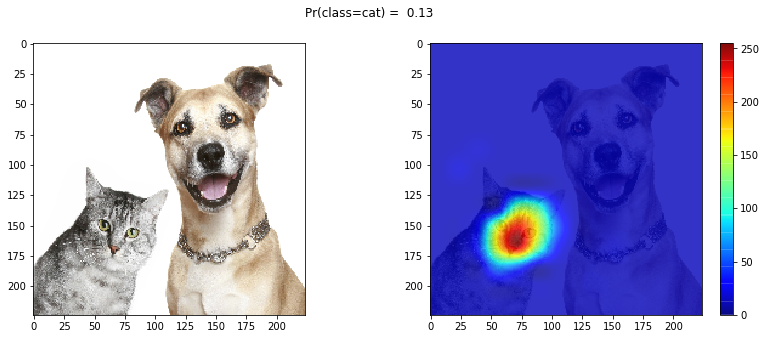

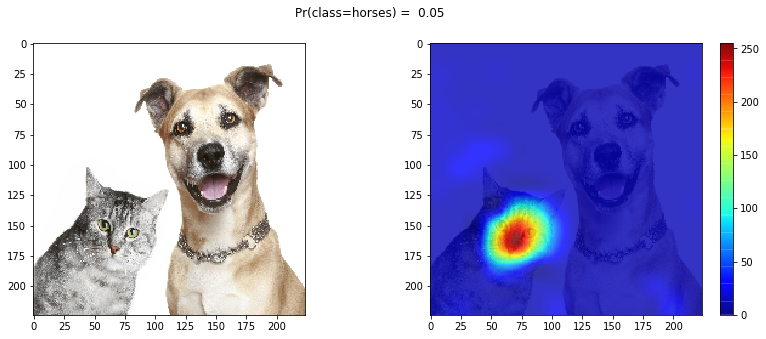

In [61]:
_img = load_img(r"E:\Dokumenty\dog_cat2.jpg",target_size=(224,224))
plt.imshow(_img)

img = img_to_array(_img)
y_pred = MODEL.predict(np.expand_dims(img/255, axis=0))
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

layer_idx = utils.find_layer_idx(MODEL, 'dense_6')
penultimate_layer_idx = utils.find_layer_idx(MODEL, "block5_conv3") 
seed_input = img

for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

Well with this mixed picture model wasnt so successful. It looked at cat and said that its dog ut definitely dog is bigger object on this picture. Anyway I dont see any difference between activation maps with softmax and linear activations (comparing horse plots).